In [19]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk import download
from glob import glob
import re
from string import punctuation
from spacy.lang.es.stop_words import STOP_WORDS
from spacy import load
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.frequent_patterns import apriori, association_rules
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import emoji
## Instancia del modelo de lenguaje
nlp = load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joako\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joako\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df = pd.read_csv("cyberbullying_tweets.csv")
df['tweet_text'].astype(str)
df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

In [3]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [4]:
#Seleccionar los valores unicos de la columna cyberbullying_type
df['cyberbullying_type'].unique()

#Seleccionar la cantidad de veces que se repite cada valor unico
#df['cyberbullying_type'].value_counts()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [28]:
# Extraer un dataframe que contenga solo las menciones y los hashtags
# Función para extraer menciones y hashtags de un texto
def extract_mentions_hashtags(text):
    mentions = re.findall(r'@[\w_]+', text)
    hashtags = re.findall(r'#[\w_]+', text)
    return mentions, hashtags

# Crear listas para las columnas del nuevo DataFrame
index_list = []
mentions_list = []
hashtags_list = []

# Iterar sobre cada fila del DataFrame original
for index, row in df.iterrows():
    mentions, hashtags = extract_mentions_hashtags(row['tweet_text'])
    
    # Verificar si hay menciones o hashtags
    if mentions or hashtags:
        # Agregar información a las listas
        index_list.append(index)
        
        # Convertir menciones y hashtags a cadenas separadas por coma o NaN si están vacías
        mentions_str = ','.join(mentions) if mentions else None
        hashtags_str = ','.join(hashtags) if hashtags else None
        
        mentions_list.append(mentions_str)
        hashtags_list.append(hashtags_str)

# Crear el nuevo DataFrame con las columnas requeridas
new_df = pd.DataFrame({
    'Index': index_list,
    'Mentions': mentions_list,
    'Hashtags': hashtags_list
})

print(new_df)

       Index          Mentions   
0          0              None  \
1          1              None   
2          2   @XochitlSuckkks   
3          3        @Jason_Gio   
4          4    @RudhoeEnglish   
...      ...               ...   
22547  47675              None   
22548  47685    @KeithBishop64   
22549  47686  @YourFavWhiteGuy   
22550  47690      @therealexel   
22551  47691     @CHILLShrammy   

                                                Hashtags  
0                                      #katandandre,#mkr  
1      #aussietv,#MKR,#theblock,#ImACelebrityAU,#toda...  
2                                                   None  
3                                                   None  
4                                                   None  
...                                                  ...  
22547                                    #coon,#joeworld  
22548                                               None  
22549                                               None  
2

In [32]:
new_df.shape

#Contar la cantidad de filas no None que contiene la columna Mentions
new_df['Hashtags'].count()


6964

In [5]:
textos = list(df["tweet_text"])


In [6]:
# Procesar los textos con NLP
docs = list(nlp.pipe(textos))
print(docs)

[In other words #katandandre, your food was crapilicious! #mkr, Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc, @XochitlSuckkks a classy whore? Or more red velvet cupcakes?, @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter., @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies., @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence., Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka, Karma. I hope it bites Kat on the butt. She is just nasty. #mkr, @stockputout everything but mostly my priest, Rebecca Black Drops Out of School Due to Bullying:, @Jord_Is_Dead http://t.co/UsQInYW5Gn, The Bully flushes on KD http://twitvid.com/A2TNP, Ughhhh #MKR, RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  

In [7]:
#calcular media y desviacion estandar de la cantidad de palabras por tweet
lens = [len(doc) for doc in docs]
print("Media: ", np.mean(lens))
print("Desviacion estandar: ", np.std(lens))

Media:  28.04407447789986
Desviacion estandar:  18.14711018011161


### Procesamiento

In [8]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [9]:
# Tokenizacion de los tweets
df['tweet_text'] = df['tweet_text'].apply(lambda x: word_tokenize(x))

In [10]:
# Eliminar stopwords y signos de puntuacion
stop_words = set(stopwords.words('english'))
df['tweet_text'] = df['tweet_text'].apply(lambda tokens: [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words])


In [11]:
# Stemming
stemmer = PorterStemmer()
df['tweet_text'] = df['tweet_text'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])


In [12]:
df['tweet_length'] = df['tweet_text'].apply(len)

In [13]:
# Ejemplo de frecuencia de palabras
all_words = [word for tokens in df['tweet_text'] for word in tokens]
fdist = FreqDist(all_words)

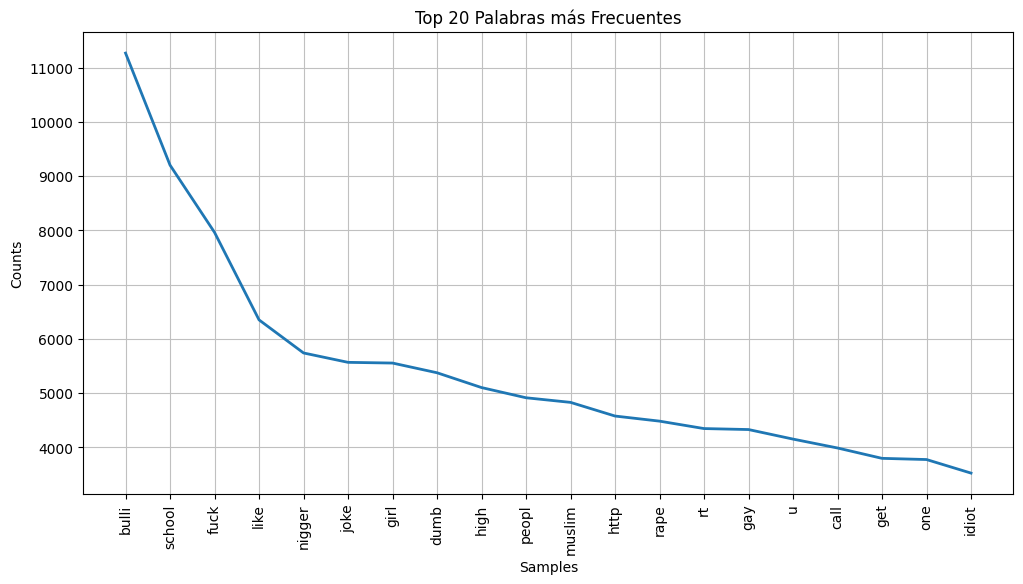

<Axes: title={'center': 'Top 20 Palabras más Frecuentes'}, xlabel='Samples', ylabel='Counts'>

In [14]:
# Plot de las 20 palabras más frecuentes
plt.figure(figsize=(12, 6))
fdist.plot(20, title='Top 20 Palabras más Frecuentes')

<Axes: title={'center': 'Distribución de Clases'}, xlabel='cyberbullying_type'>

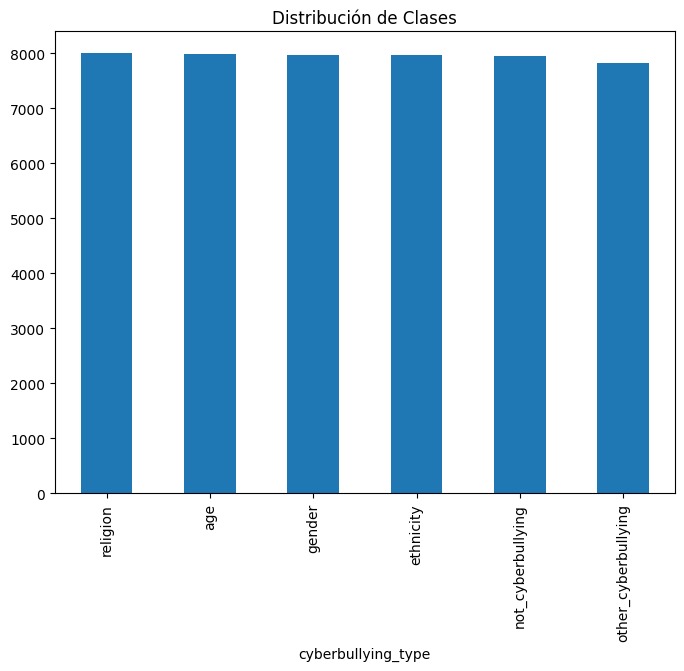

In [15]:
# Ejemplo de distribución de clases
class_distribution = df['cyberbullying_type'].value_counts()
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', title='Distribución de Clases')

In [16]:
print(df['tweet_length'].describe())

count    47692.000000
mean        13.260840
std          8.188206
min          0.000000
25%          8.000000
50%         12.000000
75%         18.000000
max        432.000000
Name: tweet_length, dtype: float64


In [17]:
df.head()

tweet_text cyberbullying_type   
0           [word, katandandr, food, crapilici, mkr]  not_cyberbullying  \
1  [aussietv, white, mkr, theblock, imacelebritya...  not_cyberbullying   
2  [xochitlsuckkk, classi, whore, red, velvet, cu...  not_cyberbullying   
3  [meh, p, thank, head, concern, anoth, angri, d...  not_cyberbullying   
4  [rudhoeenglish, isi, account, pretend, kurdish...  not_cyberbullying   

   tweet_length  
0             5  
1            11  
2             6  
3             9  
4             9

In [18]:
df[df["tweet_length"] == 432][["tweet_text"]]
df[df["tweet_length"] == 432][["tweet_text"]].values

array([[list(['feminazi', 'actual', 'word', 'nasharchi', 'job', 'mean', 'protect', 'peopl', 'even', 'peopl', 'agre', 'bare', 'cook', 'anyth', 'entré', 'mkr', 'rt', 'kf', 'like', 'commun', 'foster', 'jerk', 'prevent', 'user', 'adopt', 'commun', 'code', 'much', 'technic', 'problem', 'almost', 'time', 'jamesgweenwood', 'shock', 'your', 'bulli', 'lionlioneateat', 'yeah', 'someon', 'dmed', 'screenshot', 'meh', 'let', 'idea', 'even', 'egregi', 'case', 'harass', 'definit', 'need', 'abl', 'respond', 'appropri', 'toxic', 'happen', 'http', 'nibelsnarfabarf', 'srhbutt', 'grimachu', 'realli', 'funni', 'assumpt', 'make', 'work', 'much', 'wrong', 'lack', 'wadhwa', 'right', 'stagger', 'hilari', 'stopwadhwa2015', 'hahahaha', 'http', 'go', 'better', 'final', 'met', 'mother', 'one', 'way', 'anoth', 'trump', 'evil', 'cabal', 'crimin', 'caught', 'lie', 'ass', 'impeach', 'wo', 'b', 'moment', 'soon', 'saintneko', 'love', 'rock', 'band', 'p', 'dedic', 'thread', 'swiftonsecur', 'rt', 'srhbutt', 'women', 'gdc'